# Canonical Correlation Analysis

This is accompanying notebook for final assignment of INFO 523, University of Arizona.

I will first show on how to use CCA on a simple toy dataset, such as `titanic` dataset. Then I will show how to use it on inspecting the similarity on neural network layer.



In [1]:
import pandas as pd
import numpy as np
from sklearn.cross_decomposition import CCA
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

## CCA on Titanic dataset

I will use titanic dataset from `seaborn` library to demonstrate the usage of `scikit-learn`'s `CCA`.

In [2]:
#load titanic dataset
titanic = sns.load_dataset("titanic")

In [3]:
# peeking the head of dataset
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [4]:
# take only numeric variables, because CCA cannot work with non-numeric data.
titanic_subset = titanic[["survived", "pclass", "age", "sibsp", "parch", "fare"]]
# remove null and NA values.
titanic_subset = titanic_subset[
    titanic_subset.isnull().sum(axis=1) == 0
]

say I have two related datasets from titanic, `["pclass", "age", "sibsp"]` and `["parch", "fare", "survived"]`. Then I wanted to know how much related are these two datasets.

In [5]:
cols1 = ["pclass", "age", "sibsp"]
cols2 = ["parch", "fare", "survived"]

In [6]:
X, Y = titanic_subset[cols1], titanic_subset[cols2]
n_components = min(len(cols1), len(cols2))
cca = CCA(n_components = n_components)

cca.fit(X, Y)

CCA(n_components=3)

In [7]:
# transform the two datasets into latent variables
X_c, Y_c = cca.transform(X, Y)

I will use method shown [here](https://stackoverflow.com/questions/69800500/how-to-calculate-correlation-coefficients-using-sklearn-cca-module) to calculate the correlations from these two datasets.

In [8]:
correlations = [
    # np.corrcoef, will return square matrix
    # corr(a,a) == 1, corr(a, b) -> I will take this
    # corr(b, a)      corr(b, b) == 1
    np.corrcoef(X_c[:, i], Y_c[:, i])[0, 1] 
    for i in range(n_components)
]

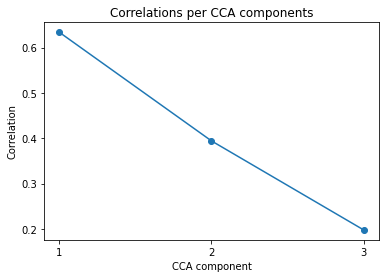

In [9]:
plt.plot(range(len(correlations)), correlations, marker="o")
plt.xticks(np.arange(3), labels=np.arange(1, 4))
plt.xlabel("CCA component")
plt.ylabel("Correlation")
plt.title("Correlations per CCA components")
plt.show()

## Inspecting neural network's activation function

Now using similar method, I will use it to neural network to compare 2 weights on the same MNIST layer from 2 fine-tuned models.

In [10]:
# Load MNIST layer number 1
with open("./MNIST/model_0_lay01.p", "rb") as f:
    acts1 = pickle.load(f)
with open("./MNIST/model_1_lay01.p", "rb") as f:
    acts2 = pickle.load(f)
    

In [11]:
assert acts1.shape == acts2.shape

print(acts1.shape)

(500, 10000)


In [12]:
# normalize activation layers
cacts1 = (acts1 - np.mean(acts1, axis=1, keepdims=True))
cacts2 = (acts2 - np.mean(acts2, axis=1, keepdims=True))

Here, instead of doing matrix factorization with SVD, as suggested by this [tutorial](https://github.com/google/svcca/blob/1f3fbf19bd31bd9b76e728ef75842aa1d9a4cd2b/tutorials/001_Introduction.ipynb), I will simply take the first 100 dimensions of the normalized activation layer, such that this article focus will be to show how to use CCA itself.

In [13]:
n_components = 100
cca = CCA(n_components = n_components)

cca.fit(cacts1[:100, :100], cacts2[:100, :100])

/Users/arie/opt/miniconda3/envs/da391/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:108: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/Users/arie/opt/miniconda3/envs/da391/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:304: UserWarning: Y residual is constant at iteration 31
  warnings.warn(f"Y residual is constant at iteration {k}")


CCA(n_components=100)

In [14]:
# transform the activation layers into latent variables
tr_acts1, tr_ccacts2 = cca.transform(cacts1[:100, :100], cacts2[:100, :100])

In [15]:
# get the correlations on each latent component between activation layer 1 and activation layer 2
correlations = np.array([
    np.corrcoef(tr_acts1[:, i], tr_ccacts2[:, i])[0, 1] for i in range(n_components)
])

/Users/arie/opt/miniconda3/envs/da391/lib/python3.9/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


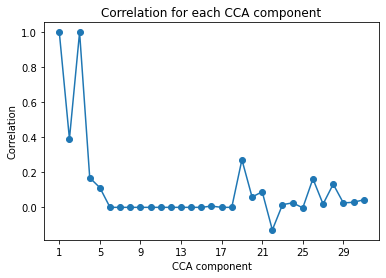

In [16]:
cors = correlations[~np.isnan(correlations)]
f, ax = plt.subplots()
plt.plot(cors, marker="o")
plt.xticks(np.arange(len(cors)), labels=np.arange(1, len(cors) + 1))
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
plt.xlabel("CCA component")
plt.ylabel("Correlation")
plt.title("Correlation for each CCA component")
plt.show()

Component 1-3 showwed that these 2 network is somewhat highly correlated, although I had only used the first 100 dimensions from each layer. Then the next question is how to interpret this result? 

The weakness of this method to show whether these 2 neural weights is then become more apparent: if I do not use all the values, should we limit the number of components? if yes then to what number? 

Ideally I should use all the weights values in the CCA, however this is computationally expensive. This is why SVD method was suggested, because of two reasons: to reduce dimenion of the activation layer itself AND to remove the headache of choosing how many number of components should I use.  


